# preliminaries

## load modules

In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data
import random
import hdbscan
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

# custom modules
from src import annotation, parameters, segmentation, spectrogramming 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load path variables

In [27]:
# to do: put these in a paths.py file and run it
all_wav_raw = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/raw/development/'
all_voc_clips_dirs = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/'
test_set_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/annotations_csv/all_annotations.csv'


# generate hdbscan labels

In [28]:
#get the final umap embeddings
coords_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/spectrograms/amplitude_segmentation/final/umap_coordinates/'
umap_embeddings = os.listdir(coords_dir)
print('available embeddings:')
for i in [i for i in umap_embeddings if i.endswith('feather')]: print(i)

available embeddings:
BW_30130x128x128_version5.feather
PO_10468x128x128_version5.feather
IS_3755x128x128_version5.feather
GO_66868x128x128_version5.feather
SW_27289x128x128_version5.feather
MZ_12045x128x128_version5.feather
LL_18371x128x128_version5.feather
MU_26543x128x128_version5.feather
LO_19429x128x128_version5.feather
NB_34079x128x128_version5.feather
BK_42244x128x128_version5.feather


In [29]:
#choose the species to process from the above list get the .feather file with each spectrogram, its source_file name, and its umap coordinates
species = 'BW'
coords = [i for i in umap_embeddings if i.startswith(species)][0]
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/'
save_name_root = coords.split(('.'))[0]

print('getting umap embedding for', coords)
print('files associated with this embedding with have the prefix', save_name_root)
df_umap = pd.read_feather(coords_dir + coords)

getting umap embedding for BW_30130x128x128_version5.feather
files associated with this embedding with have the prefix BW_30130x128x128_version5


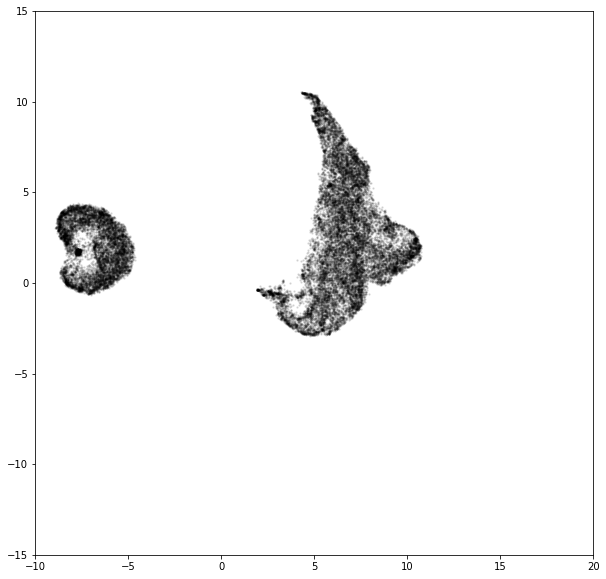

In [30]:
#show the umap plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)

pups = [i.split('_clip')[0] for i in df_umap['source_file']]
colmap = {name: n for n, name in enumerate(set(pups))}
c = [colmap[name] for name in pups]
ax = plt.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = 'k',
    s = 2,
    alpha = .1, 
    cmap='viridis')

xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.show()

# get cluster labels

In [31]:
#do SDBSCAN on UMAP coordinate JUST to separate the two clusters

data=df_umap[['umap1', 'umap2']]

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, allow_single_cluster=True).fit(data)
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

df_umap['label'] = clusterer.labels_


Text(0.5, 1.0, 'cluster_label=1')

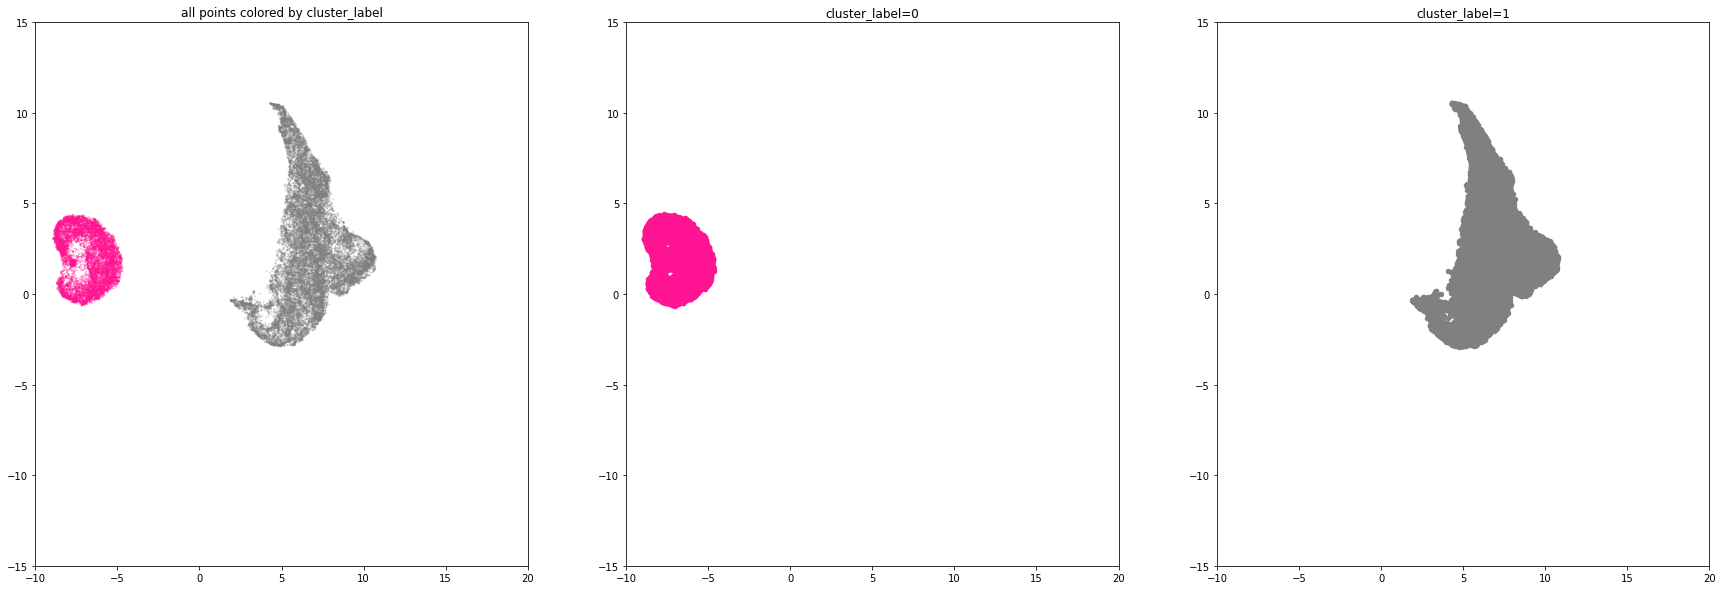

In [32]:
#show the umap plot with cluster labels and verify they correspond exactly to the clusters you see
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax3.set_xlim(xlims)
ax3.set_ylim(ylims)

ax1.scatter(
    df_umap['umap1'],
    df_umap['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

ax1.set_title('all points colored by cluster_label')

ax2.scatter(
    df_umap['umap1'].loc[df_umap['label']==0],
    df_umap['umap2'].loc[df_umap['label']==0],
    c = 'deeppink',
    s = 20,
    alpha = 1)
ax2.set_title('cluster_label=0')

ax3.scatter(
    df_umap['umap1'].loc[df_umap['label']==1],
    df_umap['umap2'].loc[df_umap['label']==1],
    c = 'grey',
    s = 20,
    alpha = 1)
ax3.set_title('cluster_label=1')

In [33]:
#count vocalizations
print('label=0:', len(df_umap.loc[df_umap['label'] == 0]))
print('label=1:', len(df_umap.loc[df_umap['label'] == 1]))

label=0: 9582
label=1: 20548


In [35]:
#save hdbscan labeled umap or not

save = False

if save:

    if save_name_root+'_labeled.feather' not in os.listdir(save_dir):
        df_umap.to_feather(save_dir+save_root+'_labeled.feather')
        print('saved to ', save_dir+save_root+'_labeled.feather')
    else: 
        print('file already exists.')
        
else:
    
    print('nothing saved')

# generate human labels

In [36]:
# check which sampling params and iterations already exist
params_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/00_params/'

if os.path.exists(params_save_dir):
    print('available sampling parameters and iterations (species_label_iteration.json):')
    for i in os.listdir(params_save_dir): print('\t',i)
else:
    print('no parameters directory found...')

available sampling parameters and iterations (species_label_iteration.json):
	 BW_hdbscanlabel1_iteration1.json
	 BW_background_iteration1.json
	 BW_hdbscanlabel0_iteration1.json
	 BW_hdbscanlabel0_iterationtest_20230111.json
	 BW_hdbscanlabel0_iteration2.json


In [37]:
#make the directories you need 

#Note: set iteration_number to iteration1 (or something) if this is the first time annotating this embedding
#update iteration_number if you want to go back and annotate more vocalizations and keep them 
#separate from previous annotations

#set the iteration number
iteration_number = 'test_20230111'

#make the directories
annotation.make_directories(save_dir=save_dir, 
                            iteration=iteration_number)

annotations directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/00_params

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel0

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel0/test_20230111

00_params directory already exists at /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/in_progress/hdbscanlabel1

00_params directory already exists at /n/hoekstra_lab_tier1/Users/nj

In [38]:
#load the labeled spectrogram embeddings
labeled_embedding = [save_dir+i for i in os.listdir(save_dir) if i.endswith('.feather')][0]
print('getting umap embedded spectrograms with labels for', labeled_embedding)
umap_labeled = pd.read_feather(labeled_embedding)
print('done.')

getting umap embedded spectrograms with labels for /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/BW_30130x128x128_version5_labeled.feather
done.


In [39]:
#spot check number of labels
umap_labeled['label'].unique()

array([1, 0])

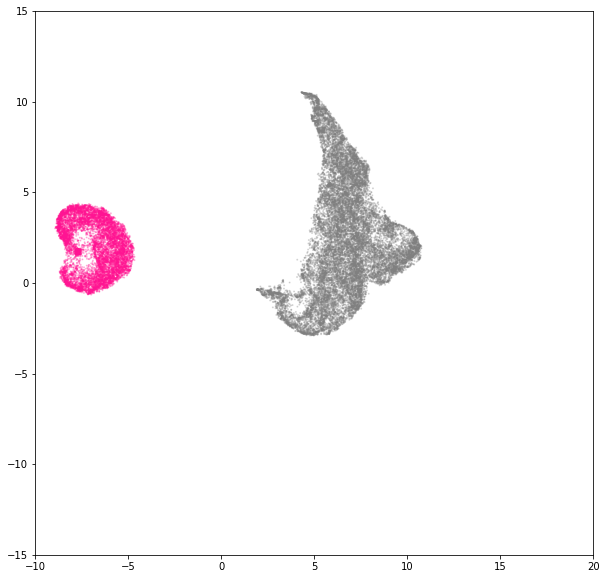

In [40]:
#show the labeled embedding
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]
plt.figure(figsize=(10,10))
xlims = [-10,20]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)
plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = 1,
    alpha = .25)

In [41]:
#or save new parameters after confirming twice you want to overwrite
clips_dir = all_voc_clips_dirs+species+'/'
print('clips_dir is', clips_dir)

#set the parameters
sampling_params = {'species': species,
                   'num_to_sample':6000, 
                   'random_state':123456, 
                   'hdbscan_label':0, 
                   'sampling_iteration':iteration_number, 
                   'clips_dir':clips_dir, 
                   'type':'sampling vocalizations from umap'}

# #set paths
params_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/00_params/'
params_save_name = sampling_params['species'] + '_hdbscanlabel'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])

#save
parameters.save_parameters(params = sampling_params,
                           save_dir=params_save_dir, 
                           save_name=params_save_name)
    

clips_dir is /n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/clips/amplitude_segmented/final/vocalization_clips/BW/
This file already exists in save_dir: BW_hdbscanlabel0_iterationtest_20230111
overwrite? y/nn
ok - no file saved


# choose parameters for hand labeling

In [42]:
# check which sampling params and iterations already exist
print('available sampling parameters and iterations (species_label_iteration.json):')
for i in os.listdir(params_save_dir): print('\t',i)

available sampling parameters and iterations (species_label_iteration.json):
	 BW_hdbscanlabel1_iteration1.json
	 BW_background_iteration1.json
	 BW_hdbscanlabel0_iteration1.json
	 BW_hdbscanlabel0_iterationtest_20230111.json
	 BW_hdbscanlabel0_iteration2.json


In [43]:
#decide to save or not
save = False

#choose your sampling parameters from the list above (exclude .json extension)
params_to_load = 'BW_hdbscanlabel0_iterationtest_20230111'

#downsample 
sampling_params = parameters.load_parameters(save_dir=params_save_dir, #get the parameters
                                             save_name=params_to_load)

if sampling_params['species'] not in ['MU', 'MZ']: #if not MU or MZ, sample from a specific label only
    ds_df = annotation.sample_vocs(frame = umap_labeled, 
                                   num_to_sample = sampling_params['num_to_sample'], 
                                   label_to_sample = sampling_params['hdbscan_label'], 
                                   random_state = sampling_params['random_state'])

if sampling_params['species'] in ['MU', 'MZ']: #if MU or MZ, sample from all vocs
    ds_df = umap_labeled.sample(n=sampling_params['num_to_sample'], 
                                random_state =  sampling_params['random_state'])
    
ds_df = ds_df.reset_index(drop=True)


#save if you want
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'downsampled_for_labeling_'+str(sampling_params['hdbscan_label'])+'_iteration'+str(sampling_params['sampling_iteration'])+'.feather'
if save:
    assert os.path.exists(os.path.join(df_save_dir))
    ds_df.to_feather(os.path.join(df_save_dir+df_save_name))
    print('saved sampled vocalizations to:\n\t', os.path.join(df_save_dir+df_save_name))
else:
    print('\nnothing saved')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/BW/annotations/00_params/BW_hdbscanlabel0_iterationtest_20230111

nothing saved


In [44]:
#load sampled vocalizations
#ds_df = pd.read_feather(os.path.join(df_save_dir+df_save_name))

#check how many are from pups in the test set
test_df = pd.read_csv(test_set_path)
in_test_set = annotation.check_test_set(ds_df, test_df)
print(len(in_test_set), 'vocs come from pups in the test set')
print('dropping them...')

#drop them
ds_df = ds_df.loc[~ds_df['source_file'].isin(in_test_set)]
print('dropped', len(in_test_set), 'vocs...')
print('there are', len(ds_df), 'remaining...')
print('done.')

0 vocs come from pups in the test set
dropping them...
dropped 0 vocs...
there are 6000 remaining...
done.


In [45]:
#TO DO this only checks one or two previous iteratons. Would be better if it checked an arbitrary number.

#if this is iteration 2, check how many are from pups in previous annotations
species = sampling_params['species']
iteration1_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration1/completed_source_files.npy'
iteration1_source_files = np.load(iteration1_source_files)

#MU has thre iterations
if sampling_params['species'] == 'MU':
    iteration2_source_files = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+species+'/annotations/in_progress/hdbscanlabel0/iteration2/completed_source_files.npy'
    iteration2_source_files = np.load(iteration2_source_files)
    already_done = [i for i in ds_df['source_file'] if (i in iteration1_source_files) or (i in iteration2_source_files)]   

already_done = [i for i in ds_df['source_file'] if i in iteration1_source_files]   
ds_df = ds_df.loc[~ds_df['source_file'].isin(already_done)]
print(len(already_done), 'vocs are already annotated')
print('dropping them...')
print('there are', len(ds_df), 'remaining...')
print('done.')


1548 vocs are already annotated
dropping them...
there are 4452 remaining...
done.


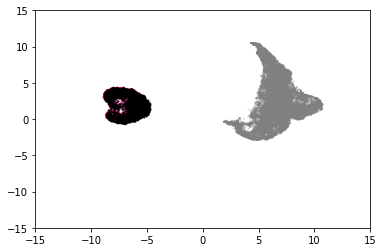

In [46]:
# plot them on top of all vocs
color_palette = sns.color_palette(['deeppink', 'grey'])
cluster_colors = [color_palette[x] for x in umap_labeled['label']]

xlims = [-15,15]
ylims = [-15,15]
plt.xlim(xlims)
plt.ylim(ylims)

plt.scatter(
    umap_labeled['umap1'],
    umap_labeled['umap2'],
    c = cluster_colors,
    s = .7,
    alpha = .25)

plt.scatter(
    ds_df['umap1'],
    ds_df['umap2'],
    c = 'k',
    s = 1,
    alpha = .5)

# Annotate

loading saved annotations...
you already annotated 20 vocalizations from this species, label, and iteration...
saving progress...
vocalization 20 of 4452 ...
BW_28987x28928_ltr3_pup2_ch3_6400_f_349_316_fr0_p11_2021-11-07_10-38-12_clip_44.wav


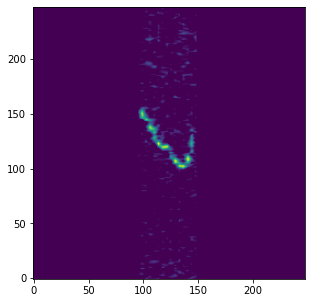

what does this look like?
type c for 'cry' | w for 'whistle' | s for 'scratch' | . for none of the above |
type u for undo | 'exit' to save and return a df of what you've annotatedexit
exiting...you've annotated 20 wav clips.
returning the labeled vocalizations to you...
done.


In [47]:
# now hand annotate them - this is easiest if this is the last cell in the notebook - consider temporaroly moving it there
# if you press a non-allowed key or undo, just re-reun this cell to start annotating from where you left off

#for viewing specs with different param than used in embedding
spec_params = {
    'min_freq': 5000, # minimum frequency
    'max_freq': 125000, # maximum frequency
    'nperseg': 512, # FFT
    'noverlap': 512 // 4, # FFT
    'spec_min_val': .1, # minimum log-spectrogram value - update from noise floors dataframe if noise_floors_path provided
    'fs': 250000, # audio samplerate
    'downsample_by':2, #2 means take every other pixel from the original spectrogram
    'fill_value': .1,
    'max_dur':.1,
    'num_time_bins':248,
    'num_freq_bins':248,
    'spec_max_val':10,
    'noise_floors_path':None
}

#set paths
in_progress_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/in_progress/'+'hdbscanlabel'+str(sampling_params['hdbscan_label'])+'/'+str(sampling_params['sampling_iteration'])+'/'
non_spec_columns = ['source_file', 'umap1', 'umap2', 'label']
df_save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'+sampling_params['species']+'/annotations/hdbscan_label_'+str(sampling_params['hdbscan_label'])+'/'
df_save_name = sampling_params['species']+'_'+'hdbscan_label'+str(sampling_params['hdbscan_label'])+str(sampling_params['sampling_iteration'])+'.feather'

#interactive annotation
hand_labeled_df = annotation.from_umap(downsampled_frame = ds_df, 
                                       num_freq_bins=128, 
                                       num_time_bins=128, 
                                       non_spec_columns=non_spec_columns, 
                                       sampling_params=sampling_params, 
                                       clips_dir=clips_dir, 
                                       in_progress_dir = in_progress_dir,
                                       spec_type='from_wav', 
                                       df_save_dir = df_save_dir, 
                                       df_save_name = df_save_name, 
                                       spec_params=spec_params)


